In [1]:
import warnings
import pathlib
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import intake
import healpy
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

In [2]:
ds = xr.open_dataset(
    "/home/b/b382728/python/NextGEMS_SynSat/scripts/synsat_tracking_zoom9.nc", 
    chunks={},
)

In [3]:
ds

<xarray.Dataset> Size: 8GB
Dimensions:             (t: 96, lat: 1500, lon: 1500)
Coordinates:
    crs                 int64 8B ...
  * t                   (t) datetime64[ns] 768B 2021-07-01T04:00:00 ... 2021-...
    cell                (lat, lon) int64 18MB dask.array<chunksize=(1500, 1500), meta=np.ndarray>
  * lat                 (lat) float64 12kB -74.95 -74.85 -74.75 ... 74.85 74.95
  * lon                 (lon) float64 12kB 285.1 285.1 285.2 ... 74.85 74.95
Data variables:
    bt                  (t, lat, lon) float64 2GB dask.array<chunksize=(96, 1500, 1500), meta=np.ndarray>
    wvd                 (t, lat, lon) float64 2GB dask.array<chunksize=(96, 1500, 1500), meta=np.ndarray>
    swd                 (t, lat, lon) float64 2GB dask.array<chunksize=(96, 1500, 1500), meta=np.ndarray>
    core_labels         (t, lat, lon) int32 864MB dask.array<chunksize=(96, 1500, 1500), meta=np.ndarray>
    thick_anvil_labels  (t, lat, lon) int32 864MB dask.array<chunksize=(96, 1500, 1500), meta=np.ndarray>
    thin_anvil_labels   (t, lat, lon) int32 864MB dask.array<chunksize=(96, 1500, 1500), meta=np.ndarray>

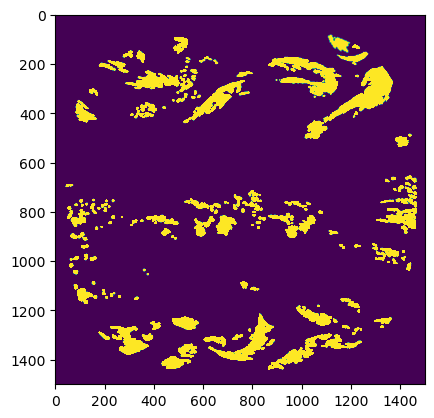

In [4]:
plt.imshow(ds.thick_anvil_labels[0], vmin=0, vmax=1)

In [5]:
order = zoom = 9
nside = hp.order2nside(order)
npix = hp.nside2npix(nside)

hp_lon, hp_lat = hp.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=True, nest=True)
hp_lon = (hp_lon % 360)
hp_lon += 360 / (4 * nside) / 4  # shift quarter-width


In [6]:
hp_lon

array([ 45.04394531,  45.13183594,  44.95605469, ..., 315.13183594,
       314.95605469, 315.04394531])

In [7]:
hp_lat

array([ 0.0746039 ,  0.14920793,  0.14920793, ..., -0.14920793,
       -0.14920793, -0.0746039 ])

In [8]:
ds_stack = ds.stack(pix=("lon", "lat"))

In [9]:
weights = egr.compute_weights_delaunay((ds_stack.lon % 360, ds_stack.lat), (hp_lon, hp_lat))


In [10]:
weights

<xarray.Dataset> Size: 116MB
Dimensions:  (tgt_idx: 3145728, tri: 3)
Dimensions without coordinates: tgt_idx, tri
Data variables:
    src_idx  (tgt_idx, tri) int32 38MB 1800751 1799251 1800750 ... 450749 449248
    weights  (tgt_idx, tri) float64 75MB 0.1855 0.06055 0.754 ... 0.754 0.06055
    valid    (tgt_idx) bool 3MB True True True True True ... True True True True

In [11]:
np.all(weights.valid)

<xarray.DataArray 'valid' ()> Size: 1B
array(False)

In [12]:
test_mask = egr.apply_weights(ds_stack.thick_anvil_labels.isel(t=0), **weights)


In [13]:
test_mask

array([0., 0., 0., ..., 0., 0., 0.])

<Figure size 640x480 with 0 Axes>

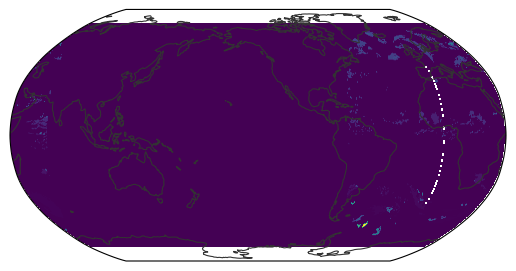

In [14]:
egh.healpix_show(test_mask)


In [15]:
# Remap entire dataset:

ds_remap = xr.apply_ufunc(
    egr.apply_weights,
    ds_stack,
    kwargs=weights,
    keep_attrs=True,
    input_core_dims=[["pix"]],
    output_core_dims=[["cell"]],
    output_dtypes=["f4"],
    vectorize=True,
    dask="parallelized",
    dask_gufunc_kwargs={
        "output_sizes": {"cell": npix},
    },
)
ds_remap

<xarray.Dataset> Size: 7GB
Dimensions:             (t: 96, cell: 3145728)
Coordinates:
    crs                 int64 8B ...
  * t                   (t) datetime64[ns] 768B 2021-07-01T04:00:00 ... 2021-...
Dimensions without coordinates: cell
Data variables:
    bt                  (t, cell) float32 1GB dask.array<chunksize=(96, 3145728), meta=np.ndarray>
    wvd                 (t, cell) float32 1GB dask.array<chunksize=(96, 3145728), meta=np.ndarray>
    swd                 (t, cell) float32 1GB dask.array<chunksize=(96, 3145728), meta=np.ndarray>
    core_labels         (t, cell) float32 1GB dask.array<chunksize=(96, 3145728), meta=np.ndarray>
    thick_anvil_labels  (t, cell) float32 1GB dask.array<chunksize=(96, 3145728), meta=np.ndarray>
    thin_anvil_labels   (t, cell) float32 1GB dask.array<chunksize=(96, 3145728), meta=np.ndarray>

In [16]:
# Test against ICON healpix data
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
dataset = cat.ICON.ngc4008(time="PT15M", zoom=9, chunks={}).to_dask()


/home/b/b382728/miniconda3/envs/tobac_flow/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [17]:
dataset

<xarray.Dataset> Size: 79TB
Dimensions:  (crs: 1, time: 1051968, cell: 3145728)
Coordinates:
  * crs      (crs) float32 4B nan
  * time     (time) datetime64[ns] 8MB 2020-01-01T00:15:00 ... 2050-01-01
Dimensions without coordinates: cell
Data variables:
    pr       (time, cell) float32 13TB dask.array<chunksize=(192, 16384), meta=np.ndarray>
    qv2m     (time, cell) float32 13TB dask.array<chunksize=(192, 16384), meta=np.ndarray>
    rlut     (time, cell) float32 13TB dask.array<chunksize=(192, 16384), meta=np.ndarray>
    rsds     (time, cell) float32 13TB dask.array<chunksize=(192, 16384), meta=np.ndarray>
    sfcwind  (time, cell) float32 13TB dask.array<chunksize=(192, 16384), meta=np.ndarray>
    tas      (time, cell) float32 13TB dask.array<chunksize=(192, 16384), meta=np.ndarray>

In [18]:
ds_remap.crs

<xarray.DataArray 'crs' ()> Size: 8B
[1 values with dtype=int64]
Coordinates:
    crs      int64 8B ...
Attributes:
    grid_mapping_name:  healpix
    healpix_nside:      512
    healpix_order:      nest

In [19]:
dataset.crs

<xarray.DataArray 'crs' (crs: 1)> Size: 4B
array([nan], dtype=float32)
Coordinates:
  * crs      (crs) float32 4B nan
Attributes:
    grid_mapping_name:  healpix
    healpix_nside:      512
    healpix_order:      nest

In [20]:
dataset.sel(time=ds_remap.t.values)

<xarray.Dataset> Size: 7GB
Dimensions:  (crs: 1, time: 96, cell: 3145728)
Coordinates:
  * crs      (crs) float32 4B nan
  * time     (time) datetime64[ns] 768B 2021-07-01T04:00:00 ... 2021-07-02T04...
Dimensions without coordinates: cell
Data variables:
    pr       (time, cell) float32 1GB dask.array<chunksize=(81, 16384), meta=np.ndarray>
    qv2m     (time, cell) float32 1GB dask.array<chunksize=(81, 16384), meta=np.ndarray>
    rlut     (time, cell) float32 1GB dask.array<chunksize=(81, 16384), meta=np.ndarray>
    rsds     (time, cell) float32 1GB dask.array<chunksize=(81, 16384), meta=np.ndarray>
    sfcwind  (time, cell) float32 1GB dask.array<chunksize=(81, 16384), meta=np.ndarray>
    tas      (time, cell) float32 1GB dask.array<chunksize=(81, 16384), meta=np.ndarray>

In [21]:
from scipy.ndimage import labeled_comprehension

In [22]:
labeled_comprehension(
    dataset.sel(time=ds_remap.t.values).pr.values.ravel(), 
    ds_remap.core_labels.values.ravel(), 
    None, 
    np.sum,
    np.float32,
    0,
)
    

130.5038

In [23]:
ds_remap.core_labels.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
var = ds_stack.core_labels.isel(t=0)


In [25]:
var[weights.src_idx]

<xarray.DataArray 'core_labels' (tgt_idx: 3145728, tri: 3)> Size: 38MB
dask.array<reshape, shape=(3145728, 3), dtype=int32, chunksize=(3145728, 3), chunktype=numpy.ndarray>
Coordinates:
    crs      int64 8B ...
    t        datetime64[ns] 8B 2021-07-01T04:00:00
    cell     (tgt_idx, tri) int64 75MB dask.array<chunksize=(3145728, 3), meta=np.ndarray>
    pix      (tgt_idx, tri) object 75MB (45.049999999993176, 0.14999999999572...
    lon      (tgt_idx, tri) float64 75MB 45.05 44.95 45.05 ... 315.0 315.0 314.9
    lat      (tgt_idx, tri) float64 75MB 0.15 0.15 0.05 ... -0.15 -0.05 -0.15
Dimensions without coordinates: tgt_idx, tri
Attributes:
    units:      K
    long_name:  Synsat SEVIRI Brightness Temperature at 10.8 um

In [26]:
from sklearn.utils.extmath import weighted_mode

In [27]:
weighted_mode(var[weights.src_idx], weights.weights, axis=1)[0].shape

(3145728, 1)

In [28]:
np.where(weights.valid, weighted_mode(var[weights.src_idx], weights.weights, axis=1)[0].squeeze(), 0)

array([0., 0., 0., ..., 0., 0., 0.])

In [29]:
def apply_weights_to_mask(mask, src_idx, weights, valid, default=0):
    """Apply given remapping weights.

    Args:
        mask (ndarray): Mask to remap using weighted mode.
        kwargs: Remapping weights as returned by `compute_weights`.

    Returns:
        ndarray: Remapped values

    See also:
        `compute_weights`
    """
    return np.where(valid, weighted_mode(var[src_idx], weights, axis=1)[0].squeeze(), default)

In [30]:
apply_weights_to_mask(ds_stack.core_labels.isel(t=0), **weights)

array([0., 0., 0., ..., 0., 0., 0.])

In [31]:
ds_stack[["core_labels", "thick_anvil_labels", "thin_anvil_labels"]]

<xarray.Dataset> Size: 3GB
Dimensions:             (t: 96, pix: 2250000)
Coordinates:
    crs                 int64 8B ...
  * t                   (t) datetime64[ns] 768B 2021-07-01T04:00:00 ... 2021-...
    cell                (pix) int64 18MB dask.array<chunksize=(2250000,), meta=np.ndarray>
  * pix                 (pix) object 18MB MultiIndex
  * lon                 (pix) float64 18MB 285.1 285.1 285.1 ... 74.95 74.95
  * lat                 (pix) float64 18MB -74.95 -74.85 -74.75 ... 74.85 74.95
Data variables:
    core_labels         (t, pix) int32 864MB dask.array<chunksize=(96, 2250000), meta=np.ndarray>
    thick_anvil_labels  (t, pix) int32 864MB dask.array<chunksize=(96, 2250000), meta=np.ndarray>
    thin_anvil_labels   (t, pix) int32 864MB dask.array<chunksize=(96, 2250000), meta=np.ndarray>

In [32]:
# Remap entire dataset:

ds_remap = xr.apply_ufunc(
    apply_weights_to_mask,
    ds_stack[["core_labels", "thick_anvil_labels", "thin_anvil_labels"]],
    kwargs=weights,
    keep_attrs=True,
    input_core_dims=[["pix"]],
    output_core_dims=[["cell"]],
    output_dtypes=["f4"],
    vectorize=True,
    dask="parallelized",
    dask_gufunc_kwargs={
        "output_sizes": {"cell": npix},
    },
)
ds_remap

<xarray.Dataset> Size: 4GB
Dimensions:             (t: 96, cell: 3145728)
Coordinates:
    crs                 int64 8B ...
  * t                   (t) datetime64[ns] 768B 2021-07-01T04:00:00 ... 2021-...
Dimensions without coordinates: cell
Data variables:
    core_labels         (t, cell) float32 1GB dask.array<chunksize=(96, 3145728), meta=np.ndarray>
    thick_anvil_labels  (t, cell) float32 1GB dask.array<chunksize=(96, 3145728), meta=np.ndarray>
    thin_anvil_labels   (t, cell) float32 1GB dask.array<chunksize=(96, 3145728), meta=np.ndarray>

In [33]:
dataset.sel(time=ds_remap.t.values).pr
    

<xarray.DataArray 'pr' (time: 96, cell: 3145728)> Size: 1GB
dask.array<getitem, shape=(96, 3145728), dtype=float32, chunksize=(81, 16384), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 768B 2021-07-01T04:00:00 ... 2021-07-02T04...
Dimensions without coordinates: cell
Attributes:
    cell_methods:  time: mean cell: mean
    component:     atmo
    grid_mapping:  crs
    long_name:     precipitation flux
    units:         kg m-2 s-1
    vgrid:         surface

In [ ]:
dataset.sel(time=ds_remap.t.values[0]).pr.groupby(ds_remap.core_labels.rename(t="time")[0]).sum()

In [ ]:
dataset.sel(time=ds_remap.t.values).pr.groupby(ds_remap.core_labels.rename(t="time")).sum()